In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [10]:
def plot_correlation(df,annot=True):
    plt.figure(figsize=(10,8))
    corr = df.corr()
    sns.heatmap(corr, annot=annot,cmap=sns.color_palette("vlag", as_cmap=True),cbar_kws={'shrink': .8},annot_kws={"size": 6} )
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [25]:
data = pd.read_csv('data/loan_data.csv')
df = data.copy()

print(df.head())

   person_age person_gender person_education  person_income  person_emp_exp  \
0        22.0        female           Master        71948.0               0   
1        21.0        female      High School        12282.0               0   
2        25.0        female      High School        12438.0               3   
3        23.0        female         Bachelor        79753.0               0   
4        24.0          male           Master        66135.0               1   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT    35000.0    PERSONAL          16.02   
1                   OWN     1000.0   EDUCATION          11.14   
2              MORTGAGE     5500.0     MEDICAL          12.87   
3                  RENT    35000.0     MEDICAL          15.23   
4                  RENT    35000.0     MEDICAL          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0                 0.49                         3.0           561  

In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [13]:
target = df["loan_status"]
# df.drop(columns="loan_status", inplace=True)

print(target)

0        1
1        0
2        1
3        1
4        1
        ..
44995    1
44996    1
44997    1
44998    1
44999    1
Name: loan_status, Length: 45000, dtype: int64


In [14]:
for col in df.columns:
    if data[col].dtype == 'object':
        print(col, data[col].unique())

person_gender ['female' 'male']
person_education ['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']
person_home_ownership ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
previous_loan_defaults_on_file ['No' 'Yes']


In [15]:
categorical_columns = [
    'person_gender', 
    'person_education', 
    'person_home_ownership', 
    'loan_intent', 
    'previous_loan_defaults_on_file'
]

In [16]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

transformer = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_columns)
    ],
    remainder='passthrough' 
)

XGBC_pipeline = Pipeline(steps=[
    ('preprocessor', transformer),
    ('classifier', XGBClassifier(
        seed = 42,
        stratified = True,
        nfold = 5,
        verbose_eval = True
    ))
])


In [24]:
print(XGBC_pipeline)
x_train,x_test,y_train,y_test = train_test_split(df, target, test_size=0.2, random_state=42)
XGBC_pipeline.fit(x_train, y_train)
print(f"validation score : {XGBC_pipeline.score(x_test, y_test)}") 

transformed_columns = XGBC_pipeline.named_steps['preprocessor'].get_feature_names_out()
transformed_data = pd.DataFrame(
    XGBC_pipeline.named_steps['preprocessor'].transform(x_train),
    columns=transformed_columns
)

print(transformed_data.columns)
loan_approval_train = transformed_data[:28800]
loan_approval_test = transformed_data[28800:]

loan_approval_train.to_csv("data/loan_approval_train.csv", index=False)
loan_approval_test.to_csv("data/loan_approval_test.csv", index=False)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['person_gender',
                                                   'person_education',
                                                   'person_home_ownership',
                                                   'loan_intent',
                                                   'previous_loan_defaults_on_file'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=N...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
              

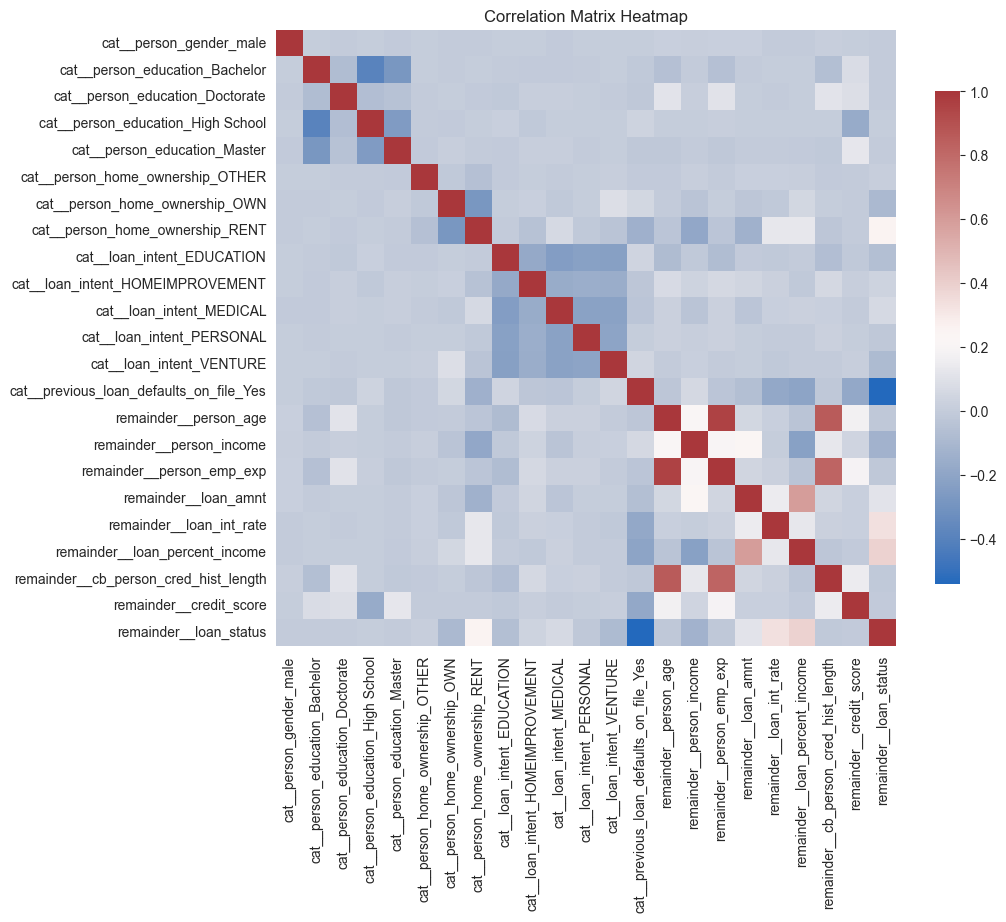

In [18]:
plot_correlation(transformed_data, False)

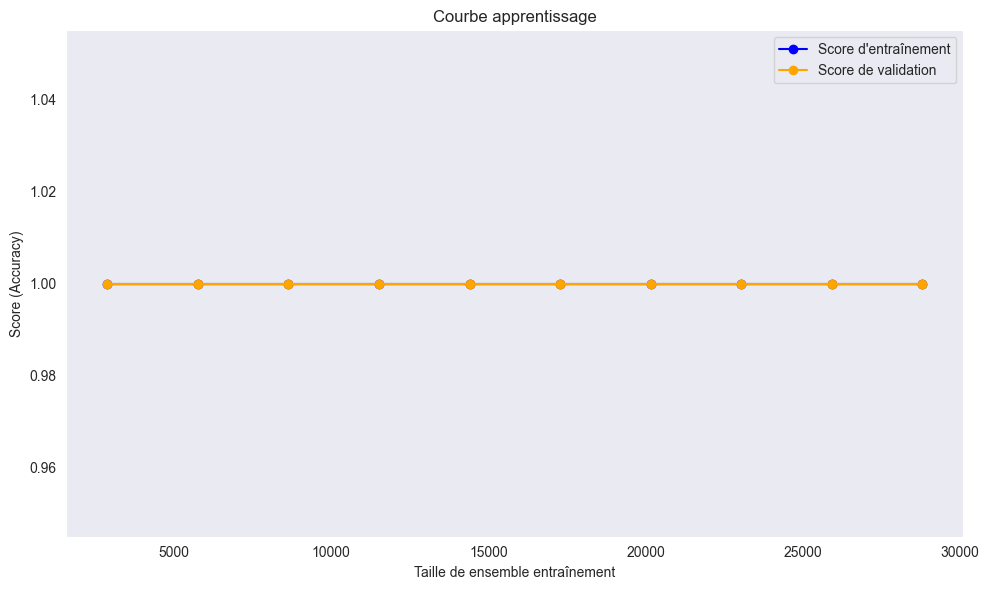

In [19]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=XGBC_pipeline,  
    X=x_train,              
    y=y_train,              
    cv=5,                    
    scoring='accuracy',     
    train_sizes=np.linspace(0.1, 1.0, 10),  
    n_jobs=-1                    
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', label='Score d\'entraînement', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.plot(train_sizes, val_mean, 'o-', label='Score de validation', color='orange')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='orange')

plt.title('Courbe apprentissage')
plt.xlabel('Taille de ensemble entraînement')
plt.ylabel('Score (Accuracy)')
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()

In [20]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],         
    'classifier__max_depth': [3, 5, 7],                
    'classifier__learning_rate': [0.01, 0.1, 0.3],      
    'classifier__subsample': [0.6, 0.8, 1.0],           
    'classifier__gamma': [0, 1, 5],                   
}


grid_search = GridSearchCV(
    estimator=XGBC_pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3, 
    n_jobs=-1,
    verbose=1
)
grid_search.fit(x_train, y_train)

# Résultats
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleure score : {grid_search.best_score_}")

# Évaluer sur les données de test
test_score = grid_search.best_estimator_.score(x_test, y_test)
print(f"Score sur les données de test : {test_score}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Meilleurs paramètres : {'classifier__gamma': 0, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 50, 'classifier__subsample': 0.6}
Meilleure score : 1.0
Score sur les données de test : 1.0
